[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CCS-ZCU/pribehy-dat/blob/master/scripts/gis.ipynb)

# GIS: Analýza prostorových dat

**autor**: *Vojtěch Kaše* (kase@ff.zcu.cz)

[![](https://ccs.zcu.cz/wp-content/uploads/2021/10/cropped-ccs-logo_black_space_240x240.png)](https://ccs.zcu.cz)

## Úvod a cíle kapitoly

V této kapitole si ukážeme základy analytické práce s prostorovými daty, tzv. GIS (=Geographic Information System). Budeme pracovat výlučně s tzv. vektorovým modelem dat, v rámci kterého jsou body, linie a plochy na mapě definovány výčtem bodů definujících zeměpisné šířky a délky. Body obsahují pouze jeden pár souřadnic (např. místo, kde se nachází strom); linie obsahují řadu párů souřadnic (např. kudy vede silnice) a plochy obsahují řadu párů souřadnic, které ohraničují určité území (např. stát).  Body, linie a plochy mohou být dále obohaceny o další atributy. 

Cvičení bude postaveno na veřejně dostupných datesetech antických nápisů v latině a řečtině. 

V rámci Pythonu pro nás bude stěžejní knihovna `geopandas`, která představuje rozšíření knihovny pandas pro práci s prostorovými daty. Základním typem dat bude tzv. `GeoDataFrame`. GeoDataFrame se chová v zásadě stejně jako DataFrame, s tím rozdílem, že obsahuje sloupec navíc, s názvem "geometry", který definuje právě zeměpisné souřadnice. Tato vlastnost umožňuje tabulková data v tomto formátu bezprostředně vykreslit do mapy.

## Cvičení

In [1]:
%%capture

# nyní si naimportujeme některé rozšiřující knihovny, které budeme níže používat (metaforicky řečeno si nasadíme nástavce...)
#!pip install mapclassify
import requests
import shutil
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
mpl.rcParams["axes.edgecolor"] = "white"
mpl.rcParams["xtick.color"] = "white"
mpl.rcParams["xtick.labelcolor"] = "white"
mpl.rcParams["ytick.color"] = "white"
mpl.rcParams["ytick.labelcolor"] = "white"
pd.set_option('display.max_columns', 100)

In [2]:
# v této buňce si náš virtuální stroj stáhneme první důležitý dataset
# dataset má přes 100MB, tudíž to pár vteřin potrvá
!curl https://zenodo.org/records/10146150/files/LIST_v1-1.parquet?download=1 --output LIST_v1-1.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  104M  100  104M    0     0  67.4M      0  0:00:01  0:00:01 --:--:-- 67.4M


In [3]:
# dataset si načteme do naší aktuální "session"
LIST = gpd.read_parquet("LIST_v1-1.parquet")

Když máme dataset načtený, můžeme s ním dále pracovat - aplikovat na něj různé funkce/metody a dále jej upravovat, filtrovat či rozšiřovat o další atributy
Podívejme se nyní v krátkosti, jak tento dataset vypadá. Oomocí metody `shape` zjístím, jaký má tabulka tvar:



In [4]:
LIST.shape

(525870, 65)

První z dvojice čísel udává počet řádků tabulky a druhá počet sloupců tabulky.

další užitečné informace získáme, necháme-li si vypsat prvních 5 řádků pomocí metody `head()`

In [5]:
LIST.head()

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,clean_text_interpretive_word_EDCS,diplomatic_text,province,place,inscr_type,status_notation,inscr_process,status,partner_link,last_update,letter_size,type_of_inscription,work_status,year_of_find,present_location,text_edition,support_objecttype,support_material,support_decoration,keywords_term,people,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,language_EDCS,raw_dating,not_after,not_before,Longitude,Latitude,is_geotemporal,geometry,is_within_RE,urban_context,urban_context_city,urban_context_pop_est,type_of_inscription_auto,type_of_inscription_auto_prob
445463,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metello imperatori I...,Q CAECILIO C F METELO / IMPERATORI ITALICI / Q...,Achaia,Agia Triada / Merbaka / Midea,tituli honorarii,"officium/professio, ordo senatorius, tria nomi...",None,officium/professio; ordo senatorius; tituli ...,http://db.edcs.eu/epigr/partner.php?s_language...,2011-11-11,None,honorific inscription,no image,NaN,None,\n Quinto Caecilio Cai filio Metelo imperatori...,None,None,1000,69,"[{'age: days': None, 'age: hours': None, 'age:...",honorific inscription,False,NaN,NaN,NaN,NULL,NULL,False,Achaia,False,Greece,False,Midea,False,Pelopónissos,False,Midhéa,False,NULL,False,None,-68 to -68,-68.0,-68.0,22.841200,37.649800,True,POINT (22.84120 37.64980),True,rural,None,NaN,honorific inscription,1.0
445464,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et Piissimo Caesari domino nostro G...,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,Achaia,Agios Athanasios / Photike,tituli honorarii,"Augusti/Augustae, ordo equester, tria nomina",litterae erasae,Augusti/Augustae; litterae erasae; ordo eque...,http://db.edcs.eu/epigr/partner.php?s_language...,2014-09-16,3-5.3 cm,honorific inscription,checked with photo,NaN,Fragma Kalama,\n Fortissimo et piissimo Caesari domino nostr...,57,None,1000,69,"[{'age: days': None, 'age: hours': None, 'age:...",honorific inscription,False,99.0,67.0,67.0,NULL,statue base,False,Epirus,False,Greece,False,Photike,False,Ípeiros,False,Paramythía,False,{Agios Athanasios},False,None,309 to 313,313.0,309.0,20.766800,39.451200,True,POINT (20.76680 39.45120),True,rural,None,NaN,honorific inscription,1.0
445465,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,ITALICEI / QVEI AEGEI NEGOTIANTVR / P RVTILIVM...,Achaia,Aigio / Egio / Aiyion / Aegeum,tituli honorarii,"officium/professio, ordo senatorius, tria nomi...",None,officium/professio; ordo senatorius; tituli ...,http://db.edcs.eu/epigr/partner.php?s_language...,2011-03-29,3.5-3.7 cm,votive inscription,checked with photo,N

In [6]:
# pro přehlednost si můžeme nechat vypsat kompletní seznam sloupců:
LIST.columns

Index(['LIST-ID', 'EDCS-ID', 'EDH-ID', 'trismegistos_uri', 'pleiades_id',
       'transcription', 'inscription', 'clean_text_conservative',
       'clean_text_interpretive_sentence', 'clean_text_interpretive_word',
       'clean_text_interpretive_word_EDCS', 'diplomatic_text', 'province',
       'place', 'inscr_type', 'status_notation', 'inscr_process', 'status',
       'partner_link', 'last_update', 'letter_size', 'type_of_inscription',
       'work_status', 'year_of_find', 'present_location', 'text_edition',
       'support_objecttype', 'support_material', 'support_decoration',
       'keywords_term', 'people', 'type_of_inscription_clean',
       'type_of_inscription_certainty', 'height_cm', 'width_cm', 'depth_cm',
       'material_clean', 'type_of_monument_clean',
       'type_of_monument_certainty', 'province_label_clean',
       'province_label_certainty', 'country_clean', 'country_certainty',
       'findspot_ancient_clean', 'findspot_ancient_certainty',
       'modern_region_cle

pro naše účely jsou mnohé atributy (sloupce) zcela nepotřebné. Pro další analýzy se proto omezíme pouze na několik z nich, a to "LIST_ID", "is_geotemporal", "urban_context", "not_before", "not_after", "Longitude", "Latitude" a "geometry".

In [7]:
# pomocí dvojitých hranatých závorek vyfiltrujme z datasetu pouze vybrané sloupce
LIST = LIST[["LIST-ID", "Longitude", "Latitude", "geometry",  "not_before", "not_after", "is_geotemporal"]]
# podívejme se na náhodný vzorek 10 nápisů:
LIST.sample(10, random_state=0)

,LIST-ID,Longitude,Latitude,geometry,not_before,not_after,is_geotemporal
154224,154225,8.646532,50.159646,POINT (8.64653 50.15965),NaN,NaN,False
96050,96051,-0.127647,51.507322,POINT (-0.12765 51.50732),NaN,NaN,False
14836,14837,10.323333,36.852778,POINT (10.32333 36.85278),NaN,NaN,False
12042,12043,10.323333,36.852778,POINT (10.32333 36.85278),NaN,NaN,False
484994,484995,8.218500,47.479900,POINT (8.21850 47.47990),14.0,101.0,True
463957,463958,15.639756,38.103539,POINT (15.63976 38.10354),101.0,300.0,True
161939,161940,8.418749,49.446920,POINT (8.41875 49.44692),NaN,NaN,False
435997,435998,11.914244,45.800727,POINT (11.91424 45.80073),NaN,NaN,False
453536,453537,0.784608,43.432245,POINT (0.78461 43.43224),71.0,100.0,True
393190,393191,12.482932,41.893320,POINT (12.48293 41.89332),301.0,400.0,True


Atribut ve sloupci "LIST-ID" obsahuje jednoznačný číselný identifikátor daného nápisu v našem datasetu.

Atributy "Longitude" a "Latitude" vyjadřují zeměpisnou délku a šířku.

Stejná informace je i ve sloupci "geometry". To však není jen tak ledajaký sloupec! Je to sloupec, který z našich dat dělá prostorová data zpracovatelná knihovnou `geopandas`. Data ve sloupci "geometry"  tvoří tzv. [`GeoSeries`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.html#geopandas-geoseries) a celá tabulka je díky nim takzvaný [`GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). Hodnoty zeměpisné šířky a délky jsou zde specificky naformátované a samotné číselné hodnoty předchází slovo "POINT". Definuje se zde, že se jedná o bodové geometrie (formátování jednotlivých prvků vychází ze standardů  python knihovny [Shapely](https://shapely.readthedocs.io/en/stable/manual.html)). Díky těmto vlastnostem lze daná tabulková data bezprostředně použít k nejrůznějším prostorovým operacím, z nichž některé si za okamžik ukážeme.

Sloupce `not_before` a `not_after` vyjadřují časovou informaci. Definují, ze kdy daný nápis pochází. S historickými daty jsme často jako badatelé v situaci, kdy tuto dataci neznáme přesně, jsme schopni pouze schopni vyjádřit informovaný odhad ve formě intervalu. V případě antiky jsme velké množství objektů schopni datovat pouze do konkrétního století (např. 4. stol.n.l.). To lze pak číselně vyjádřit intervalem 301-400, jako je tomu v případě posledního nápisu v našem vzorku. V jiných případech daný objekt obsahuje indície, které umožňují mnohem přesnější dataci (například tím, že odkazují k nějaké známé historické události). V takovém případě je hodnota `not_before` a `not_after` totožná.

Sloupec "is_geotemporal" obsahuje boolovské hodnoty *Pravda* (True) nebo *Nepravda* (False) odvozené z hodnot ve sloupcích "geometry", "not_before" a "not_after". Hodnota True je zde tehdy, pokud má nápis jak validní nenulovou geometrie a tak informaci o dataci, což v našem datasetu není vždy tak.

Tento sloupec  nyní využijeme k dodatečnému filtrování našich dat, kdy se omezíme pouze na položku, kdy tento atribut má hodnotu True.

In [8]:
LIST = LIST[LIST["is_geotemporal"]]
LIST.shape

(206570, 7)

opět jsme použili metodu shape, abychom se podívali, jaký má náš dataset nyní "tvar". Vidíme, že po filtrování sestává pouze z cca. dvou set tisíc položek a osmi sloupců.

Další důležitá vlastnost našeho `GeoDataFrame` objektu se skrývá za atributem `crs`. Tato tři písmena představují zkratku. Věděli bychom jakou? Zkusme se podívat na výsledek:

In [9]:
LIST.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Nyní již můžeme postoupit k první prostorové vizualizaci:

<Axes: >

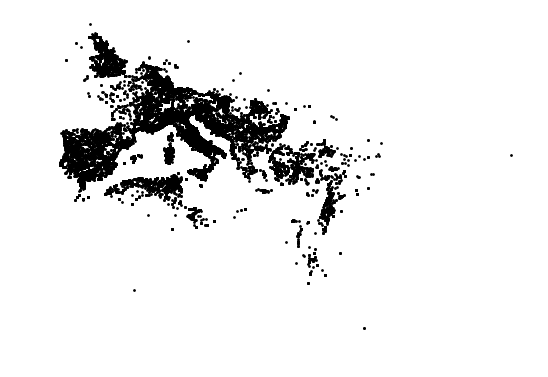

In [10]:
LIST.plot(color="black", markersize=1)

Výsledek není nijak atraktivní a sám o sobě asi i těžko interpretovatelný. V podstatě jsme jen vykreslili do prostoru o něco málo více než 200 000 tisíc bodů. V dalších krocích tohoto workshopu však dostatneme tuto vizualizaci do vizuálně přitažlivější podoby...

V následujícím kroku si načteme další dataset. Tentokrát přímo z webového odkazu:

In [11]:
provinces = gpd.read_file("https://raw.githubusercontent.com/sdam-au/GI_ETL/master/data/provinces_valid.geojson")

In [12]:
# opět si nejprve prohlédneme pět prvních řádek atributové tabulky
provinces.head()

,province,geometry
0,Achaia,"MULTIPOLYGON (((25.87933 36.27113, 25.88242 36..."
1,Alpes Poeninae,"POLYGON ((6.88843 45.93874, 7.22626 45.93205, ..."
2,Alpes Graiae,"POLYGON ((7.22626 45.93181, 7.17407 45.60443, ..."
3,Umbria (Regio VI),"POLYGON ((13.29895 43.67383, 13.03253 43.84641..."
4,Picenum (Regio V),"POLYGON ((14.19640 42.48754, 14.28738 42.42700..."


In [13]:
provinces.shape

(61, 2)

In [14]:
provinces.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Tento dataset má pouze dva sloupce: "province" a opět "geometry". Vidíme však, že sloupec "geometry" vypadá nyní odlišně. Na první řádce čteme "MULTIPOLYGON" a na dalších řádcích "POLYGON". Naše geometrie zde tedy již nesestávají z bodů ale z ploch. Jak název napovídá, jedná se o provincie, a totiž o provincie Římské říše, její hlavní správní celky, obdoba např. českých krajů (viz [Římské provincie](https://cs.wikipedia.org/wiki/%C5%98%C3%ADmsk%C3%A9_provincie)).

I tento dataset si můžeme velice přímočaře vizualizovat pomocí metody `plot()`, nejprve samostatně a následně společně s naším datasetem nápisů jakožto vrchní vrstvou:

<Axes: >

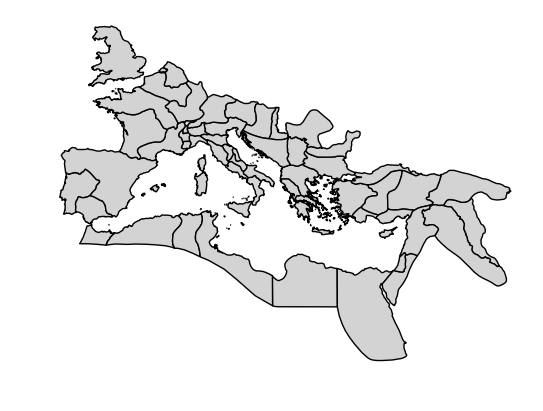

In [15]:
provinces.plot(color="lightgrey", edgecolor="black")

<Axes: >

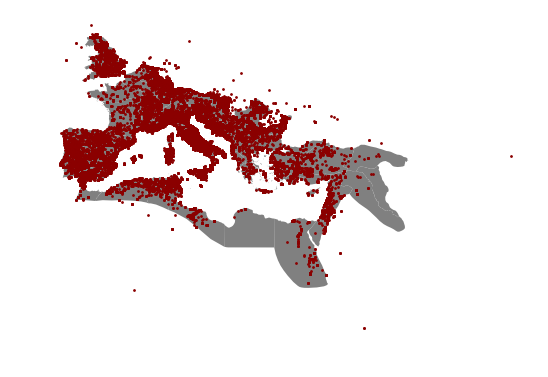

In [16]:
ax = provinces.plot(color="grey")
LIST.plot(markersize=1, ax=ax, color="darkred")

Vidíme zde, že oba datasety se týkají téhož území, avšak že bodu v ploše nejsou zdaleka rovnoměrně rozprostřeny a mnohé se nacházejí zcela vně polygonů provincií. To si zaslouží bližší ohledání.

Nejprve pro každý územní celek (provincii) sečteme počet nápisů, které se v ní nacházejí. Využijeme metody `contains()` (určení pro všechny prvky z datasetu nápisů, zda sa nacházejí či nenacházejí uvnitř onoho území (True nebo False)).a `sum()` (sečtení všech prvků s hodnotou True.


In [17]:
%%time
provinces["LIST_n"] = provinces.geometry.apply(lambda x: x.contains(LIST.geometry).sum())
provinces.head(5)

CPU times: user 15.1 s, sys: 9.18 ms, total: 15.1 s
Wall time: 15.2 s


,province,geometry,LIST_n
0,Achaia,"MULTIPOLYGON (((25.87933 36.27113, 25.88242 36...",548
1,Alpes Poeninae,"POLYGON ((6.88843 45.93874, 7.22626 45.93205, ...",145
2,Alpes Graiae,"POLYGON ((7.22626 45.93181, 7.17407 45.60443, ...",128
3,Umbria (Regio VI),"POLYGON ((13.29895 43.67383, 13.03253 43.84641...",2962
4,Picenum (Regio V),"POLYGON ((14.19640 42.48754, 14.28738 42.42700...",1296


v datasetu provincií nyní máme informaci o tom, kolik se uvnitř ní nachází nápisů. Provincie jsou ale různě velké, a tudíž samotné číslo nemá příliš velkou výpovědní hodnotu. Spočítejme tedy nyní plochu jednotlivých provincií a vytvořme si nový atribut s názvem "area". Pro tento výpočet si pomocí metody `to_crs` převedeme do metrické projekce EPSG:3035 a získáme plochu v metrech čtverečních. Kilomtery čtvereční získáme, když výsledné hodnoty vydělíme miliónem.

In [18]:
provinces["area_km2"] = provinces.to_crs(3035).area / 1000000
provinces.head(5)

,province,geometry,LIST_n,area_km2
0,Achaia,"MULTIPOLYGON (((25.87933 36.27113, 25.88242 36...",548,42867.393436
1,Alpes Poeninae,"POLYGON ((6.88843 45.93874, 7.22626 45.93205, ...",145,3744.947681
2,Alpes Graiae,"POLYGON ((7.22626 45.93181, 7.17407 45.60443, ...",128,3554.922799
3,Umbria (Regio VI),"POLYGON ((13.29895 43.67383, 13.03253 43.84641...",2962,12388.703393
4,Picenum (Regio V),"POLYGON ((14.19640 42.48754, 14.28738 42.42700...",1296,6425.024998


Pro každou provincii tedy nyní máme a) množtví latinských nápisů, které z ní pocházejí a b) rozsah jejího území v kilometrech čtverečních. Jak získáme hustotu?

In [19]:
provinces["LIST_density"] = provinces["LIST_n"] / provinces["area_km2"]

Data si prohlédneme uspořádaná od položek s největší hodnotou tohoto nového atributu:

In [20]:
provinces.sort_values("LIST_density", ascending=False, inplace=True)
provinces.head(5)

,province,geometry,LIST_n,area_km2,LIST_density
60,Roma,"POLYGON ((12.47017 41.87876, 12.47309 41.87090...",75301,15.378988,4896.355840
6,Latium et Campania (Regio I),"POLYGON ((12.46262 41.61544, 12.35687 41.69753...",96662,18396.867450,5.254264
5,Samnium (Regio IV),"POLYGON ((15.04337 41.97506, 14.95514 41.96715...",3214,13378.892647,0.240229
3,Umbria (Regio VI),"POLYGON ((13.29895 43.67383, 13.03253 43.84641...",2962,12388.703393,0.239089
4,Picenum (Regio V),"POLYGON ((14.19640 42.48754, 14.28738 42.42700...",1296,6425.024998,0.201711


Vydíme zde výraznou vyjímečnost dat z města Říma (první řádek) a jeho nejbližšího okolí (Lacia, první polygon je současně obsažen v druhém), kde máme řádově vyšší hodnoty, než kdekoli jinde. Proto je z následující vizualizace vyloučíme.

Danou hodnotu vyjádříme prostřednictvím baravného odstínu příslušné provincie:

<Axes: >

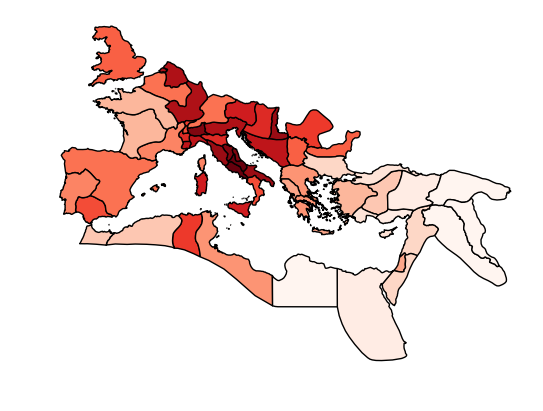

In [21]:
provinces.plot(column=provinces["LIST_density"], cmap="Reds", edgecolor="black", scheme="Quantiles", k=20)

Vidíme, že latinské nápisy se akumulují převážně v západní části Římské říše. To je i území, o němž víme, že na něm dominovala latina. Zatímco ve východní části říše dominovala řečtina.

Proto si nyní stáhneme a načteme ještě jeden dataset. Opět se jedná o dataset nápisů, tentokrát však v řečtině.


In [22]:
# nyní si stáhneme a načteme ještě jeden dataset. Opět se jedná o dataset nápisů, tentokrát však v řečtině-
!curl https://zenodo.org/records/10139110/files/GIST_v1-1.parquet?download=1 --output GIST_v1-1.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  131M  100  131M    0     0  74.2M      0  0:00:01  0:00:01 --:--:-- 74.2M


In [23]:
GIST = gpd.read_parquet("GIST_v1-1.parquet")
GIST.shape

(217863, 36)

Opět se omezíme pouze na vybrané atributy, které budou s výjimkou první (identifikátor) totožné jako v předchozím případě: "PHI_ID", "Longitude", "Latitude", "geometry",  "not_before", "not_after" a  "is_geotemporal". Současně rovnou provedeme filtraci a omezíme se pouze na ty s validní geometrií a datací.


In [24]:
GIST = GIST[["PHI_ID", "Longitude", "Latitude", "geometry", "not_before", "not_after", "is_geotemporal"]]
GIST = GIST[GIST["is_geotemporal"]]
GIST.sample(10, random_state=0)

,PHI_ID,Longitude,Latitude,geometry,not_before,not_after,is_geotemporal
47383,185052,30.427700,46.566770,POINT (30.42770 46.56677),-146.0,324.0,True
67219,219005,29.907915,31.198246,POINT (29.90791 31.19825),-181.0,-146.0,True
178395,352103,27.277706,37.521576,POINT (27.27771 37.52158),101.0,300.0,True
154108,322993,23.790535,38.398169,POINT (23.79053 38.39817),-300.0,-201.0,True
138665,304414,33.137081,34.712264,POINT (33.13708 34.71226),101.0,300.0,True
136009,301449,23.156733,47.179329,POINT (23.15673 47.17933),127.0,156.0,True
6718,42142,22.673318,38.581724,POINT (22.67332 38.58172),98.0,98.0,True
17418,81079,23.790535,38.398169,POINT (23.79053 38.39817),-100.0,-1.0,True
163090,332919,13.197536,37.967275,POINT (13.19754 37.96728),-330.0,-30.0,True
117575,278488,29.063819,40.182899,POINT (29.06382 40.18290),-105.0,-30.0,True


Následně si můžeme opět minimalisticky vizualizovat všechny tyto nápisy společně s našimi dalšími dvěma datasety:

<Axes: >

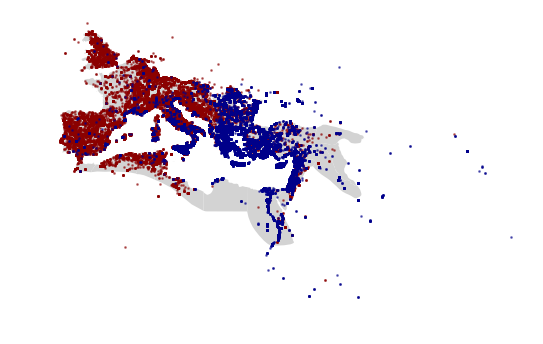

In [25]:
ax = provinces.plot(color="lightgrey")
LIST.plot(markersize=1, ax=ax, color="darkred", alpha=0.5)
GIST.plot(markersize=1, ax=ax, color="darkblue", alpha=0.5)

Vidíme zde poměrně jasný prostorový vzor. Povšimneme, že řecké nápisy dominují od dnešního Chorvatska směrem dále na východ. Pojďme ale toto pozorování rozpracovat numericky. Spočtěme si počty řeckých nápisů v jednotlivých provinciích a též jejich hustoty.

In [26]:
provinces["GIST_n"] = provinces.geometry.apply(lambda x: x.contains(GIST.geometry).sum())
provinces["GIST_density"] = provinces["GIST_n"] / provinces["area_sk"]

KeyError: ignored

# Samostatný úkol: počet a hustota řeckých nápisů uvnitř jednotlivých provincií:

Povšimli jsme si, že dataset řeckých nápisů `GIST` má obdobnou strukturu jako dataset latinských nápisů `LIST`.

V případě latinských nápisů jsme výše také spočítali jejich počet uvnitř jednotlivých provincií v datasetu `provinces`, když jsme zde aplikovali funkce `contains()` a `sum()`. Dataset `provinces` jsme tak obohatili o nový atribut s názvem `"LIST_n"`. Dále jsme vytvořili atribut `"area_sk"` a nakonec - za využití těchto dvou předchozích atributů - atribut `"LIST_density"`.

Vašim **samostatným úkolem** nyní je obohatit dataset `provinces` o dva další atributy, které budou obsahovat informace o počtech a hustotě řeckých nápisů z datasetu `GIST`. Nazvete je `"GIST_n"` a "`GIST_density`".

(Nápověda: V zásadě jde o to buněk níže zkopírovat a mírně poupravit několik řádek kódu, které jsme použili výše k vytvoření atributů `"LIST_n"` a `"LIST_density"`.)



In [27]:
# ÚKOL 1
# přidejme k datasetu provinces atribut "GIST_n" (za využití kombinace funkcí apply(), contains() a sum() - viz výše v případě latinských nápisů)



In [28]:
# výsledek si prohlédneme:
provinces.head(5)

In [29]:
# ÚKOL 2:
# přidejme k datasetu provinces atribut "GIST_density" (počty nápisů v atributu "GIST_n" vydělíme hustutou v atributu "area_sk" - viz obdobný výpočet výše v případě latinských nápisů)



Pokud jsme postupovali správně, půjdou nám spustit i buňky kódu níže.

In [30]:
fig, ax1 = plt.subplots()
provinces.plot(column=provinces["GIST_density"], cmap="Blues", edgecolor="black", scheme="Quantiles", k=20, ax=ax1)

# tentokrát si vytvoříme i legendu
# budeme postupovat krok po kroku, abychom měli plnou kontrolu
mpl.rcParams["ytick.labelcolor"] = "black"
vmin = np.round(provinces["GIST_density"].min(), 2)
vmax = np.round(provinces["GIST_density"].max(), 2)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1, orientation='horizontal', shrink=0.5)
cbar.set_ticks([vmin, vmax])
cbar.set_label('GIST density (inscriptions per km$^2$)')

Nyní zkombinujeme oba datasety dohromady

In [32]:
# součet řeckých a latinských nápisů
provinces["GLIST_n"] = provinces["LIST_n"] + provinces["GIST_n"]

In [33]:
# hustota součtu řeckých a latinských nápisů
provinces["GLIST_density"] = provinces["GLIST_n"] / provinces["area_sk"]

In [34]:
# proporcionální zastoupení latinských nápisů na škále od jedné do nuly (1=pouze latinské, 0=pouze řecké)
provinces["LIST_proportion"] = provinces["LIST_n"] / provinces["GLIST_n"]

In [35]:
fig, ax1 = plt.subplots()
provinces.plot(column=provinces["LIST_proportion"], cmap="seismic", edgecolor="black", ax=ax1)
ax1.set_yticklabels([])
ax1.set_xticklabels([])

mpl.rcParams["xtick.labelcolor"] = "black"
sm = plt.cm.ScalarMappable(cmap='seismic') #, norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(sm, ax=ax1, orientation='horizontal', shrink=0.5)
cbar.set_ticks([0, 0.5, 1])
cbar.set_label('LIST proportion (0=no latin; 1=latin only)')

In [36]:
fig.savefig("figures/provinces_list-proportion.png")
#files.download("provinces_list-proportion.png")

# Rozšiřující analýza: časový rozměr

In [37]:
%%capture
# doinstalujeme si knihovnu pro práci s "časovou nejistotou" v historických datech: https://pypi.org/project/tempun/
!pip install tempun
import tempun

In [38]:
# datace jednotlivých nápisů jsou v tuto chvíli vyjádřeny interval, s touto formou dat se rozložení dat v čase špatně analyzuje
# datační interval využijeme nyní k tomu, že si každý nápis datujeme do jednoho konkrétního roku ohraničeného tímto intervalem
# POZOR: provedení tohoto příkazu trvá několik minut
def get_one_random_year(row):
  year = tempun.model_date(row["not_before"], row["not_after"], size=2)[0]
  return year
GIST["year"] = GIST.apply(lambda row: get_one_random_year(row), axis=1)
LIST["year"] = LIST.apply(lambda row: get_one_random_year(row), axis=1)

In [39]:
# vytvoříme histogram distribuce nápisů v čase
fig, ax = plt.subplots()
GIST["year"].hist(color="darkred", bins=range(-800,600,50), histtype='step', ax=ax)
LIST["year"].hist(color="darkblue", bins=range(-800,600,50), histtype='step', ax=ax)
ax.set_ylabel("N of inscriptions")
ax.set_xlabel("year")

In [40]:
# vytvoříme mapu všech nápisů datovaných před naším letopočtem (nahoře) a našeho letopočtu (dole)
fig, [ax1,ax2] = plt.subplots(2,1, dpi=300, tight_layout=True)

provinces.plot(color="lightgrey", ax=ax1)
GIST[GIST["year"]<=0].plot(color="darkblue", alpha=0.5, markersize=1, ax=ax1)
LIST[LIST["year"]<=0].plot(color="darkred", alpha=0.5, markersize=1, ax=ax1)
ax1.set_xlim(-10,50)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_title("All inscriptions BCE")

provinces.plot(color="lightgrey", ax=ax2)
GIST[GIST["year"]>0].plot(color="darkblue", markersize=1,alpha=0.5, ax=ax2)
LIST[LIST["year"]>0].plot(color="darkred", markersize=1, alpha=0.5, ax=ax2)
ax2.set_xlim(-10,50)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_title("All inscriptions CE")
